In [ ]:
# import the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('nyc_taxi_trip_duration.csv')
# Dataset is now stored in a Pandas Dataframe
# we take only a part of the data since it takes a lot of processing time and power for the knn elbow curve 

data.shape

(195811, 11)

In [ ]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1.0,-73.953918,40.778873,-73.963875,40.771164,N,400.0
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2.0,-73.988312,40.731743,-73.994751,40.694931,N,1100.0
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2.0,-73.997314,40.721458,-73.948029,40.774918,N,1635.0
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6.0,-73.961670,40.759720,-73.956779,40.780628,N,1141.0
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1.0,-74.017120,40.708469,-73.988182,40.740631,N,848.0


In [ ]:
# load the dataset and view the shape

data = pd.read_csv('nyc_taxi_trip_duration.csv')
data.shape

(195811, 11)

In [ ]:
# remove rows where the trip_duration is less than 30 sec and more than 20 hours as they may be outliers

data = data[(data['trip_duration'] >= 30) & (data['trip_duration'] < 20*3600)]

In [ ]:
# convert 'pickup_datetime' and 'dropoff_datetime' into datetime objects

data['pickup_datetime'] = pd.to_datetime(data.pickup_datetime)
data['dropoff_datetime'] = pd.to_datetime(data.dropoff_datetime)

In [ ]:

# extract hour and day of the week from the respective features

data['pickup_hour'] = data['pickup_datetime'].dt.hour
data['dropoff_hour'] = data['dropoff_datetime'].dt.hour

data['pickup_dayofweek'] = data['pickup_datetime'].dt.dayofweek
data['dropoff_dayofweek'] = data['dropoff_datetime'].dt.dayofweek


In [ ]:
# drop the unnecessary columns

drop_cols = ['id', 'pickup_datetime', 'dropoff_datetime']
data.drop(columns = drop_cols, inplace = True)

In [ ]:
# dealing with the outliers
# outliers are the ones less than 1.5 times than the IQR and the ones above 1.5 times the IQR

Q1 = data.trip_duration.quantile(0.25)
Q3 = data.trip_duration.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# replace the outliers with the mean
outliers = data[(data['trip_duration'] < lower_bound) | (data['trip_duration'] > upper_bound)]
print("Number of outliers in trip_duration column:", len(outliers))

data.loc[(data['trip_duration'] < lower_bound) | (data['trip_duration'] > upper_bound), 'trip_duration'] = data['trip_duration'].mean()

Number of outliers in trip_duration column: 9818


In [ ]:
# look at the total number of different values of 'passenger_count'

data.passenger_count.value_counts()

1.0    137883
2.0     28358
5.0     10342
3.0      8066
6.0      6522
4.0      3789
0.0         5
Name: passenger_count, dtype: int64

In [ ]:
# remove the rows where passenger_count = 0 or 9

data=data[(data.passenger_count!=0) | (data.passenger_count != 0)]

In [ ]:
data.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,dropoff_hour,pickup_dayofweek,dropoff_dayofweek
0,2,1.0,-73.953918,40.778873,-73.963875,40.771164,N,400.0,16,16,0,0
1,1,2.0,-73.988312,40.731743,-73.994751,40.694931,N,1100.0,23,23,4,4
2,2,2.0,-73.997314,40.721458,-73.948029,40.774918,N,1635.0,17,18,6,6
3,2,6.0,-73.961670,40.759720,-73.956779,40.780628,N,1141.0,9,10,1,1
4,1,1.0,-74.017120,40.708469,-73.988182,40.740631,N,848.0,6,6,2,2


In [ ]:
# convert the categorial values into binary vector representation

data = pd.get_dummies(data, columns=['vendor_id', 'pickup_dayofweek', 'dropoff_dayofweek','store_and_fwd_flag'])

In [ ]:
# print the first five rows of the encoded dataframe

from IPython.display import display
display(data.head())

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_hour,dropoff_hour,vendor_id_1,vendor_id_2,...,pickup_dayofweek_6,dropoff_dayofweek_0,dropoff_dayofweek_1,dropoff_dayofweek_2,dropoff_dayofweek_3,dropoff_dayofweek_4,dropoff_dayofweek_5,dropoff_dayofweek_6,store_and_fwd_flag_N,store_and_fwd_flag_Y
0,1.0,-73.953918,40.778873,-73.963875,40.771164,400.0,16,16,0,1,...,0,1,0,0,0,0,0,0,1,0
1,2.0,-73.988312,40.731743,-73.994751,40.694931,1100.0,23,23,1,0,...,0,0,0,0,0,1,0,0,1,0
2,2.0,-73.997314,40.721458,-73.948029,40.774918,1635.0,17,18,0,1,...,1,0,0,0,0,0,0,1,1,0
3,6.0,-73.961670,40.759720,-73.956779,40.780628,1141.0,9,10,0,1,...,0,0,1,0,0,0,0,0,1,0
4,1.0,-74.017120,40.708469,-73.988182,40.740631,848.0,6,6,1,0,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
# divide the data for training and testing

from sklearn.model_selection import train_test_split

X = data.drop('trip_duration', axis=1) # Feature matrix
y = data['trip_duration'] # Target variable

# Splitting the data into 80% training set and 20% testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Preprocess data using StandardScaler

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# import the KNeighborsRegressor class and to create instances of the model

from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.metrics import mean_squared_error as MSE, r2_score, mean_absolute_error as MAE

In [ ]:
# function to plot the elbow curve to find the best value of k

def Elbow(K):
  #initiating empty list
    test_mse = []
  
  #training model for evey value of K
    for i in K:
        #Instance of KNN
        reg = KNN(n_neighbors = i)
        reg.fit(X_train_scaled, y_train)
        #Appending mse value to empty list claculated using the predictions
        tmp = reg.predict(X_test_scaled)
        tmp = MSE(tmp, y_test)
        test_mse.append(tmp)
    
    return test_mse

In [ ]:
# plot elbow curve for odd values of k from 1 to 13 since checking for all the values takes a lot of processing power and time

k = range(1,15,2)
test = Elbow(k)

Text(0.5, 1.0, 'Elbow Curve for test')

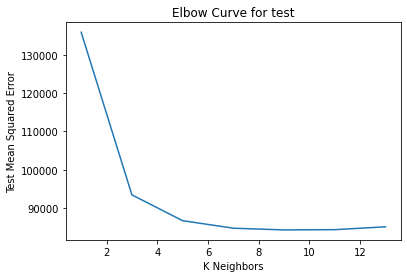

In [ ]:
plt.plot(k, test)
plt.xlabel('K Neighbors')
plt.ylabel('Test Mean Squared Error')
plt.title('Elbow Curve for test')

In [ ]:
# from the plot we can say that the best value of k is 7

reg = KNN(n_neighbors = 7)

# Fitting the model
reg.fit(X_train_scaled, y_train)

# predicting the values for X_test_scaled
y_pred = reg.predict(X_test_scaled)

In [ ]:
# looking at the performance of the model

print('Test MSE    ', MSE(y_pred, y_test))
print('MAE: ', MAE(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

Test MSE     84787.66415989603
MAE:  213.38235635158975
R-squared: 0.5506956610302238
